# Dengue Outbreak Detection Using LSTM Autoencoder
Prepared by: Hieng MAO

In [1]:
!nvidia-smi

Thu May  1 10:21:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:CA:00.0 Off |                    0 |
|  0%   55C    P0             82W /  300W |   41838MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [61]:
MODEL_FILE_NAME = 'dengue_outbreak_detection2_100epochs_mse.h5'
RANDOM_SEED = 42

## Dataset

In [136]:
df = pd.read_csv('dengue-2013-2023.csv')

print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [137]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]

In [6]:
print(df.head())
print(df.describe())
print(df.info())

   Year PROVINCE  Week_no  Count
0  2013  Bangkok        1    351
1  2013  Bangkok        2    399
2  2013  Bangkok        3    300
3  2013  Bangkok        4    280
4  2013  Bangkok        5    262
               Year       Week_no         Count
count  43389.000000  43389.000000  43389.000000
mean    2017.896126     26.207518     21.276107
std        3.117756     14.929032     50.750883
min     2013.000000      1.000000      0.000000
25%     2015.000000     13.000000      2.000000
50%     2018.000000     26.000000      7.000000
75%     2021.000000     39.000000     21.000000
max     2023.000000     53.000000   2166.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43389 entries, 0 to 43388
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      43389 non-null  int64 
 1   PROVINCE  43389 non-null  object
 2   Week_no   43389 non-null  int64 
 3   Count     43389 non-null  int64 
dtypes: int64(3), object(1)
memory

In [138]:
# Count all cases by province
df_province = df.groupby('PROVINCE')['Count'].sum().sort_values(ascending=False).reset_index()
print("Top 10 Provinces with Most Cases:")
print(df_province.head(10))

Top 10 Provinces with Most Cases:
              PROVINCE   Count
0              Bangkok  109244
1           Chiang Mai   42376
2    Nakhon Ratchasima   41708
3           Chiang Rai   35968
4             Songkhla   30365
5     Ubon Ratchathani   29365
6  Nakhon Si Thammarat   27060
7                Surin   23976
8             Chonburi   23701
9               Rayong   20426


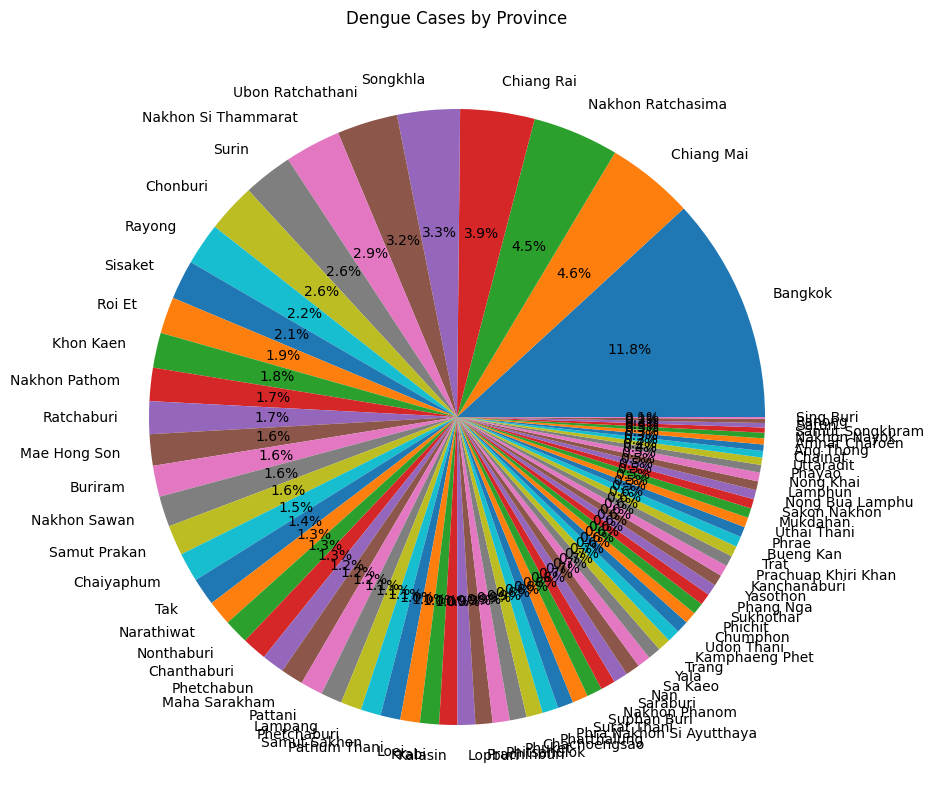

In [140]:
df_province.set_index('PROVINCE')['Count'].plot.pie(autopct='%1.1f%%', figsize=(10, 10))
plt.ylabel('')  # Hide the y-label
plt.title('Dengue Cases by Province')
plt.show()


In [141]:
df_province.describe()

,Count
count,77.000000
mean,11988.948052
std,14201.908752
min,883.000000
25%,5206.000000
50%,7900.000000
75%,14067.000000
max,109244.000000


In [8]:
# Keep the original dataframe but have it sorted based on the total count per province
df['Total_Count'] = df['PROVINCE'].map(df_province.set_index('PROVINCE')['Count'])
df_sorted = df.sort_values(by='Total_Count', ascending=False).reset_index(drop=True)
df_sorted.head()

,Year,PROVINCE,Week_no,Count,Total_Count
0,2013,Bangkok,51,199,109244
1,2018,Bangkok,1,142,109244
2,2013,Bangkok,5,262,109244
3,2013,Bangkok,26,285,109244
4,2013,Bangkok,27,347,109244


In [9]:
# Re-assign back to dataframe
df = df_sorted[['Year', 'PROVINCE', 'Week_no', 'Count']]
df.head()

,Year,PROVINCE,Week_no,Count
0,2013,Bangkok,51,199
1,2018,Bangkok,1,142
2,2013,Bangkok,5,262
3,2013,Bangkok,26,285
4,2013,Bangkok,27,347


In [10]:
COUNT_THRESHOLD = 100

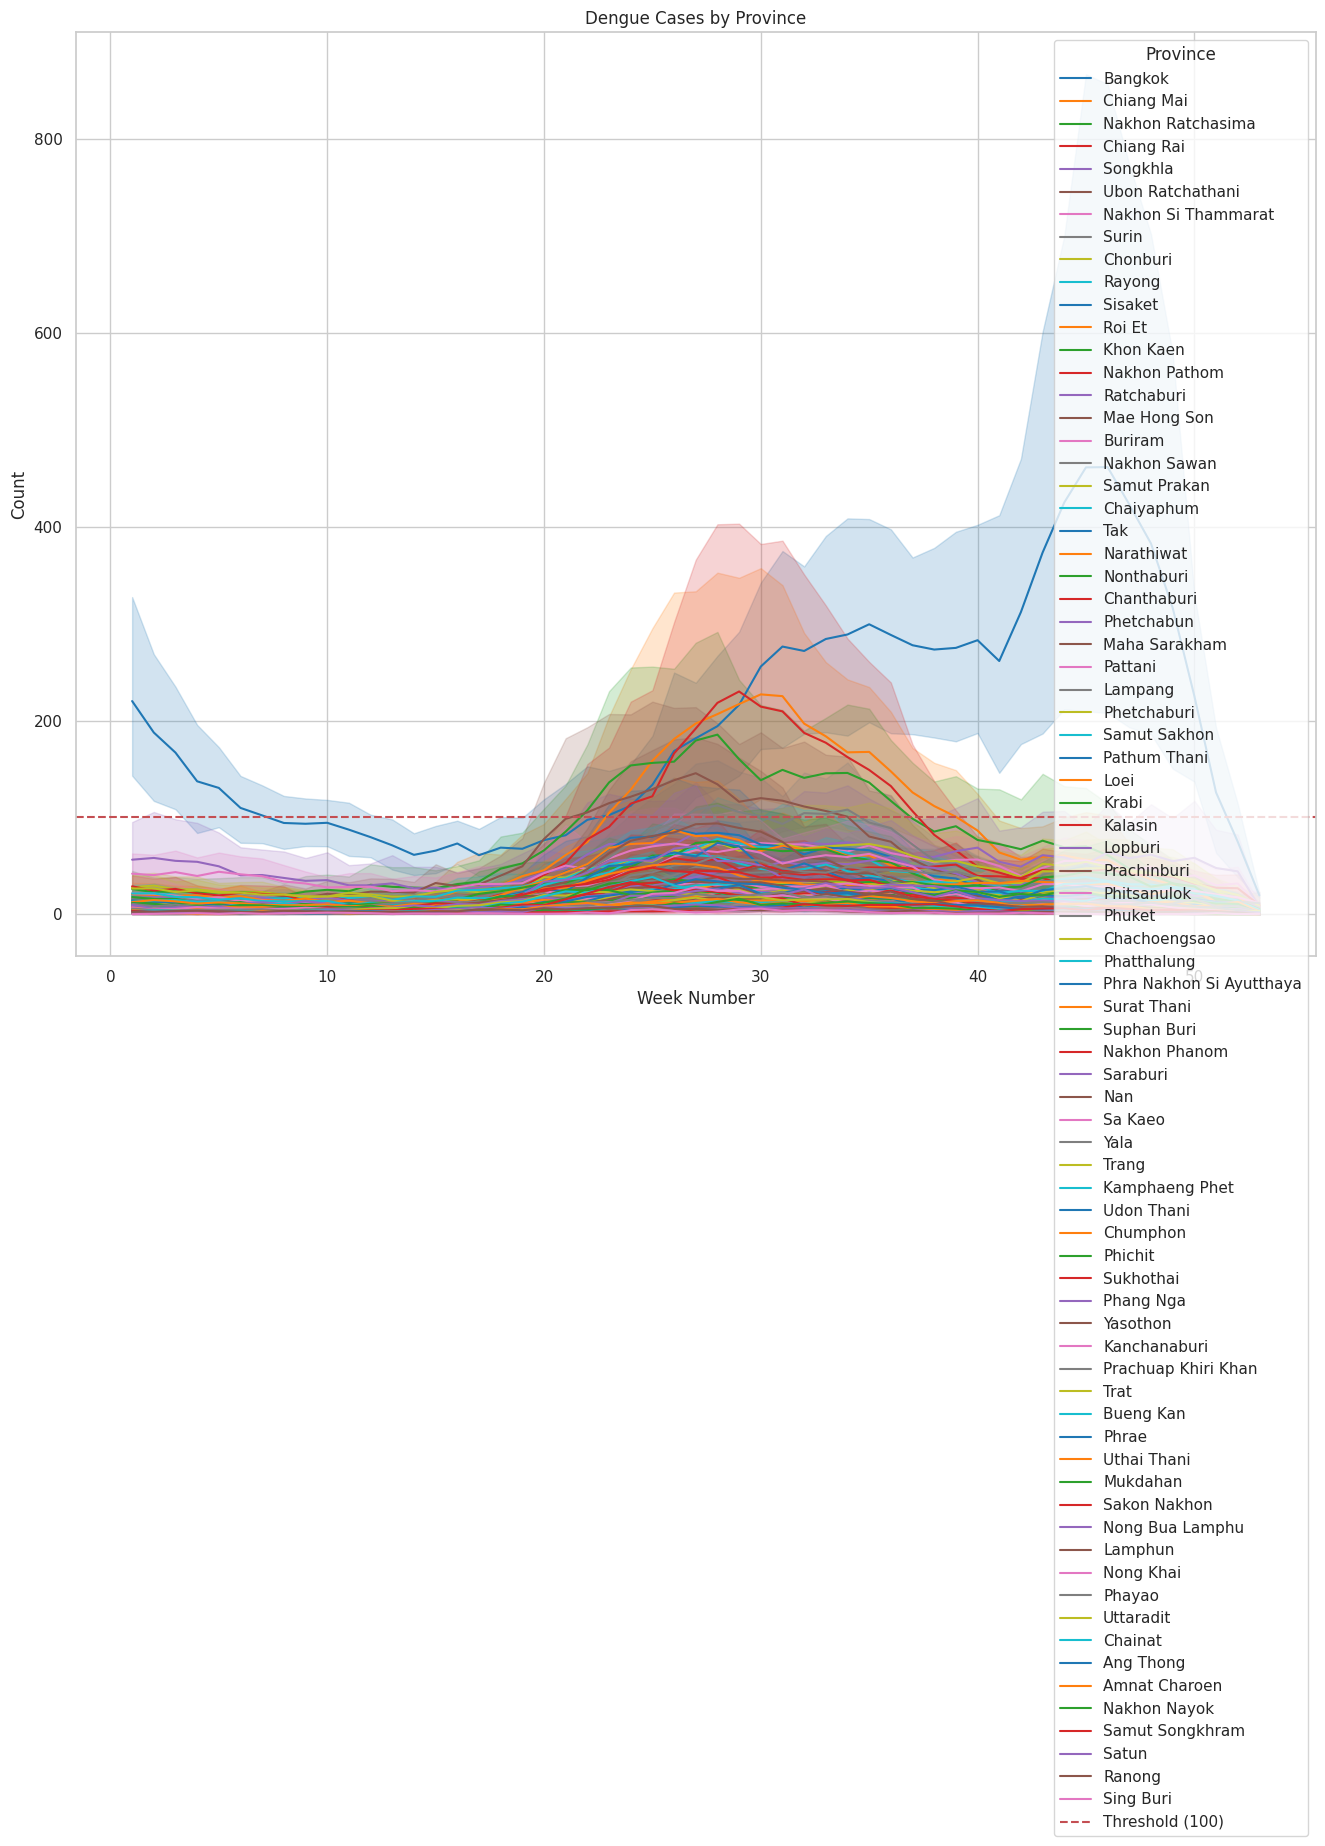

In [26]:
# Plotting the data
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='Week_no', y='Count', hue='PROVINCE', palette='tab10')
# Add a dot lines for a threshold
plt.axhline(y=COUNT_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({COUNT_THRESHOLD})')
plt.title('Dengue Cases by Province')
plt.xlabel('Week Number')
plt.ylabel('Count')
plt.legend(title='Province')
plt.show()

**Insights**
- By looking the graph, we can see that the hight number of dengue counts happen mostly between **week 25 to 32 for most provinces**. This indicate that the warning of the dengue should start between these weeks.
- We can draw/pick a **Count Threshold** to define that the value below the threshold counted as **NORMAL**, since the above threshold counted as **ABNORMAL**.

In [ ]:
# province_order = df_province['PROVINCE'].tolist()
# print(province_order)

In [ ]:
# # Convert PROVINCE to a categorical type with ordered categories
# df.loc[:, 'PROVINCE'] = pd.Categorical(df['PROVINCE'], categories=province_order, ordered=True)

# # Now sort by PROVINCE (preserving order), then Year, then Week_no
# df = df.sort_values(by=['PROVINCE', 'Year', 'Week_no'])

# df.head()

Most Affected Province: Bangkok between 2013 and 2023
<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 0 to 562
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      563 non-null    int64 
 1   PROVINCE  563 non-null    object
 2   Week_no   563 non-null    int64 
 3   Count     563 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 22.0+ KB
None


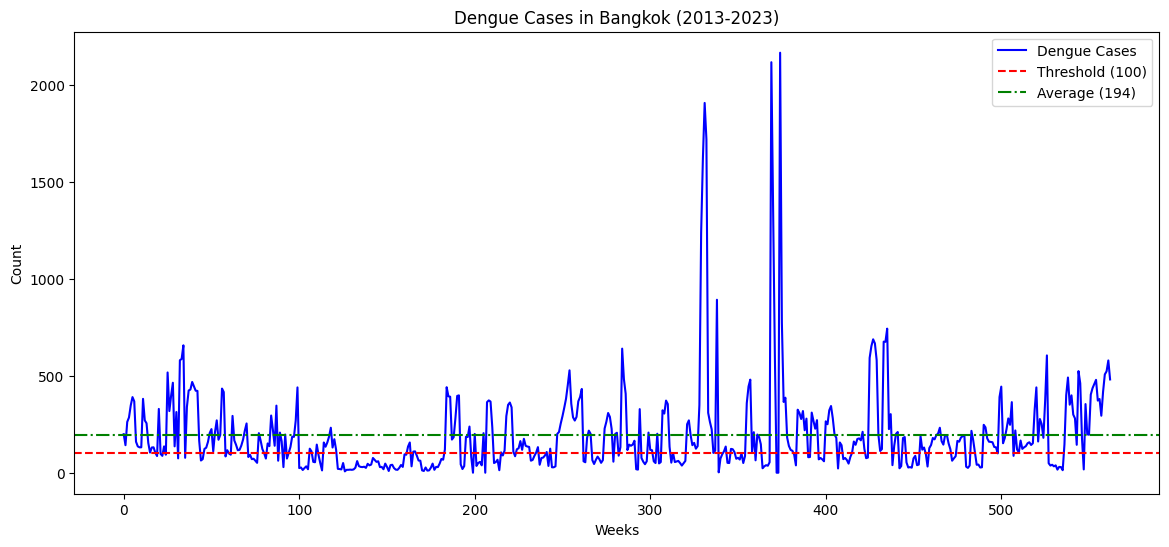

In [11]:
# Visualize the most affected province
most_affected_province = df_province.iloc[0]['PROVINCE']
most_affected_df = df[df['PROVINCE'] == most_affected_province]
min_year, max_year = most_affected_df['Year'].min(), most_affected_df['Year'].max()

print(f"Most Affected Province: {most_affected_province} between {min_year} and {max_year}")
print(most_affected_df.info())

plt.figure(figsize=(14,6))
plt.plot(most_affected_df['Count'].values, label='Dengue Cases', color='blue')

# Add a dot lines for a threshold
plt.axhline(y=COUNT_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({COUNT_THRESHOLD})')

# Add a dot line for the average
avg = most_affected_df['Count'].mean().round().astype(int)
plt.axhline(y=avg, color='g', linestyle='-.', label=f'Average ({avg})')
# Add alert threshold
# alert_threshold = 550
# plt.axhline(y=alert_threshold, color='orange', linestyle='--', label=f'Alert Threshold ({alert_threshold})')
# Optional: Fill the area above the alert threshold
# plt.fill_between(range(len(most_affected_df)), alert_threshold, most_affected_df['Count'].values, where=(most_affected_df['Count'].values > alert_threshold), color='orange', alpha=0.3)
plt.title(f'Dengue Cases in {most_affected_province} ({min_year}-{max_year})')
plt.xlabel('Weeks')
plt.ylabel('Count')
plt.legend()
plt.show()

### Data Scaling & Splitting

We scale the data before further splitting:

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
scaled_df = df.copy()
scaled_df['PROVINCE'] = le.fit_transform(scaled_df['PROVINCE'])

scaled_df.head()

,Year,PROVINCE,Week_no,Count
0,2013,2,51,199
1,2018,2,1,142
2,2013,2,5,262
3,2013,2,26,285
4,2013,2,27,347


In [77]:
province_code_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(province_code_mapping)

{0: 'Amnat Charoen', 1: 'Ang Thong', 2: 'Bangkok', 3: 'Bueng Kan', 4: 'Buriram', 5: 'Chachoengsao', 6: 'Chainat', 7: 'Chaiyaphum', 8: 'Chanthaburi', 9: 'Chiang Mai', 10: 'Chiang Rai', 11: 'Chonburi', 12: 'Chumphon', 13: 'Kalasin', 14: 'Kamphaeng Phet', 15: 'Kanchanaburi', 16: 'Khon Kaen', 17: 'Krabi', 18: 'Lampang', 19: 'Lamphun', 20: 'Loei', 21: 'Lopburi', 22: 'Mae Hong Son', 23: 'Maha Sarakham', 24: 'Mukdahan', 25: 'Nakhon Nayok', 26: 'Nakhon Pathom', 27: 'Nakhon Phanom', 28: 'Nakhon Ratchasima', 29: 'Nakhon Sawan', 30: 'Nakhon Si Thammarat', 31: 'Nan', 32: 'Narathiwat', 33: 'Nong Bua Lamphu', 34: 'Nong Khai', 35: 'Nonthaburi', 36: 'Pathum Thani', 37: 'Pattani', 38: 'Phang Nga', 39: 'Phatthalung', 40: 'Phayao', 41: 'Phetchabun', 42: 'Phetchaburi', 43: 'Phichit', 44: 'Phitsanulok', 45: 'Phra Nakhon Si Ayutthaya', 46: 'Phrae', 47: 'Phuket', 48: 'Prachinburi', 49: 'Prachuap Khiri Khan', 50: 'Ranong', 51: 'Ratchaburi', 52: 'Rayong', 53: 'Roi Et', 54: 'Sa Kaeo', 55: 'Sakon Nakhon', 56: 'S

We Split data for Normal and Abnormal.

In [46]:
normal_df = scaled_df[scaled_df['Count'] <= COUNT_THRESHOLD]
abnormal_df = scaled_df[scaled_df['Count'] > COUNT_THRESHOLD]
print(f"Normal Dataframe Shape: {normal_df.shape}")
print(f"Abnormal Dataframe Shape: {abnormal_df.shape}")
print(f"Normal Dataframe Percentage: {normal_df.shape[0] / scaled_df.shape[0] * 100:.2f}%")
print(f"Abnormal Dataframe Percentage: {abnormal_df.shape[0] / scaled_df.shape[0] * 100:.2f}%")

Normal Dataframe Shape: (41802, 4)
Abnormal Dataframe Shape: (1587, 4)
Normal Dataframe Percentage: 96.34%
Abnormal Dataframe Percentage: 3.66%


We further scale the data using MinMaxScaler:

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaled_normal_df = normal_df.copy()
scaled_abnormal_df = abnormal_df.copy()

scaler = MinMaxScaler()
scaled_normal_df[['Year', 'PROVINCE', 'Week_no', 'Count']] = scaler.fit_transform(scaled_normal_df[['Year', 'PROVINCE', 'Week_no', 'Count']])
scaled_abnormal_df[['Year', 'PROVINCE', 'Week_no', 'Count']] = scaler.transform(scaled_abnormal_df[['Year', 'PROVINCE', 'Week_no', 'Count']])
print(scaled_normal_df.head())
print(scaled_abnormal_df.head())

    Year  PROVINCE   Week_no  Count
19   1.0  0.026316  0.288462   0.86
21   0.5  0.026316  0.019231   0.97
22   0.5  0.026316  0.038462   0.87
24   0.5  0.026316  0.115385   0.93
31   0.4  0.026316  0.288462   0.74
   Year  PROVINCE   Week_no  Count
0   0.0  0.026316  0.961538   1.99
1   0.5  0.026316  0.000000   1.42
2   0.0  0.026316  0.076923   2.62
3   0.0  0.026316  0.480769   2.85
4   0.0  0.026316  0.500000   3.47


We'll split the normal examples into train, validation and test sets:

In [49]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
  scaled_normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

print(f"Train Dataframe Shape: {train_df.shape}")
print(f"Validation Dataframe Shape: {val_df.shape}")
print(f"Test Dataframe Shape: {test_df.shape}")
print(train_df.head())

Train Dataframe Shape: (35531, 4)
Validation Dataframe Shape: (4201, 4)
Test Dataframe Shape: (2070, 4)
       Year  PROVINCE   Week_no  Count
13854   0.3  0.539474  0.711538   0.07
6673    0.7  0.697368  0.442308   0.52
29545   0.4  0.565789  0.019231   0.02
18936   0.8  0.171053  0.596154   0.08
37386   0.6  0.447368  0.923077   0.00


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [50]:
TIME_STEPS = 4

In [51]:
import torch

# Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features
# The number of features is 4 (Year, Province, Week_no, Count)
# The sequence length is the number of weeks in the time series
def create_dataset(df, sequence_length=4):
  """
  Create a dataset from the dataframe
  Args:
    df: DataFrame containing the data
    sequence_length: Length of the sequence to create
  Returns:
    sequences: Tensor containing the sequences
  """
  sequences = []
  for i in range(len(df) - sequence_length):
    seq = df.iloc[i:i + sequence_length].values
    sequences.append(seq)
  return torch.tensor(sequences, dtype=torch.float32).to(device)

train_sequences = create_dataset(train_df, TIME_STEPS)
val_sequences = create_dataset(val_df, TIME_STEPS)
test_sequences = create_dataset(test_df, TIME_STEPS)
test_abnormal_sequences = create_dataset(scaled_abnormal_df, TIME_STEPS)

print(f"Train Sequences Shape: {train_sequences.shape}")
print(f"Validation Sequences Shape: {val_sequences.shape}")
print(f"Test Sequences Shape: {test_sequences.shape}")
print(f"Test Abnormal Sequences Shape: {test_abnormal_sequences.shape}")
print(train_sequences[0])
print(train_sequences[1])
print(train_sequences[2])

Train Sequences Shape: torch.Size([35527, 4, 4])
Validation Sequences Shape: torch.Size([4197, 4, 4])
Test Sequences Shape: torch.Size([2066, 4, 4])
Test Abnormal Sequences Shape: torch.Size([1583, 4, 4])
tensor([[0.3000, 0.5395, 0.7115, 0.0700],
        [0.7000, 0.6974, 0.4423, 0.5200],
        [0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800]], device='cuda:0')
tensor([[0.7000, 0.6974, 0.4423, 0.5200],
        [0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800],
        [0.6000, 0.4474, 0.9231, 0.0000]], device='cuda:0')
tensor([[0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800],
        [0.6000, 0.4474, 0.9231, 0.0000],
        [0.9000, 0.2105, 0.7692, 0.1100]], device='cuda:0')


## Model Architecture
[Reference](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb) 

In [52]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):  # x: (batch, seq_len, n_features)
        x, _ = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n[-1]  # shape: (batch, embedding_dim)

The Encoder uses two LSTM layers to compress the Time Series data input.

In [53]:
from torch import nn

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=4):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):  # x: (batch, input_dim)
        # Expand latent vector across time steps
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch, seq_len, input_dim)

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        return self.output_layer(x)  # (batch, seq_len, n_features)


Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [54]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [55]:
batch_size = 16
seq_len = 4
n_features = 4
embedding_dim = 64

test_model = RecurrentAutoencoder(seq_len, n_features, embedding_dim).to(device)
dummy_input = torch.randn(batch_size, seq_len, n_features).to(device)

print("Input shape:", dummy_input.shape)
output = test_model(dummy_input)
print("Output shape:", output.shape)


Input shape: torch.Size([16, 4, 4])
Output shape: torch.Size([16, 4, 4])


In [56]:
batch_size = 16
seq_len = TIME_STEPS
n_features = 4
embedding_dim = 64

model = RecurrentAutoencoder(seq_len, n_features, embedding_dim).to(device)
model = model.to(device)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.L1Loss(reduction='sum').to(device)
criterion = nn.MSELoss().to(device)

In [58]:
import copy 
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, optimizer, criterion, train_dataset, val_dataset, n_epochs=50, batch_size=16):
  history = dict(train=[], val=[])

  # train_dataset = TensorDataset(train_sequences)  # wrap tensor in dataset
  # val_dataset = TensorDataset(val_sequences)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true_batch in train_loader:
      optimizer.zero_grad()

      seq_true = seq_true_batch.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true_batch in val_loader:

        seq_true = seq_true_batch.to(device)
        val_pred = model(seq_true)

        loss = criterion(val_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the **MAE (mean absolute error)**. Why? The reconstructions seem to be better than with **MSE (mean squared error)**.

In [59]:
epochs = 100

In [60]:
model, history = train_model(model, optimizer, criterion, train_sequences, val_sequences, n_epochs=epochs)

Epoch 1: train loss 0.036302790242297184 val loss 0.005263115674214784
Epoch 2: train loss 0.002538712114763045 val loss 0.001026594641967234
Epoch 3: train loss 0.0003999504747922972 val loss 0.00029281629110020747
Epoch 4: train loss 0.00019166230573607184 val loss 0.00023693478017330113
Epoch 5: train loss 0.0001415765756551395 val loss 0.0001809989316756359
Epoch 6: train loss 0.00011796492812498286 val loss 5.5074141220390594e-05
Epoch 7: train loss 9.26485982462399e-05 val loss 7.34202764584628e-05
Epoch 8: train loss 8.72552894772078e-05 val loss 6.549623431885764e-05
Epoch 9: train loss 7.313787545324014e-05 val loss 0.00013955146383149762
Epoch 10: train loss 6.535232200027877e-05 val loss 7.417142892111635e-05
Epoch 11: train loss 6.265244054428681e-05 val loss 7.334873094362872e-05
Epoch 12: train loss 5.422446427040666e-05 val loss 6.801821678760019e-05
Epoch 13: train loss 5.340889826008153e-05 val loss 5.354320794707359e-05
Epoch 14: train loss 4.609456150755717e-05 val l

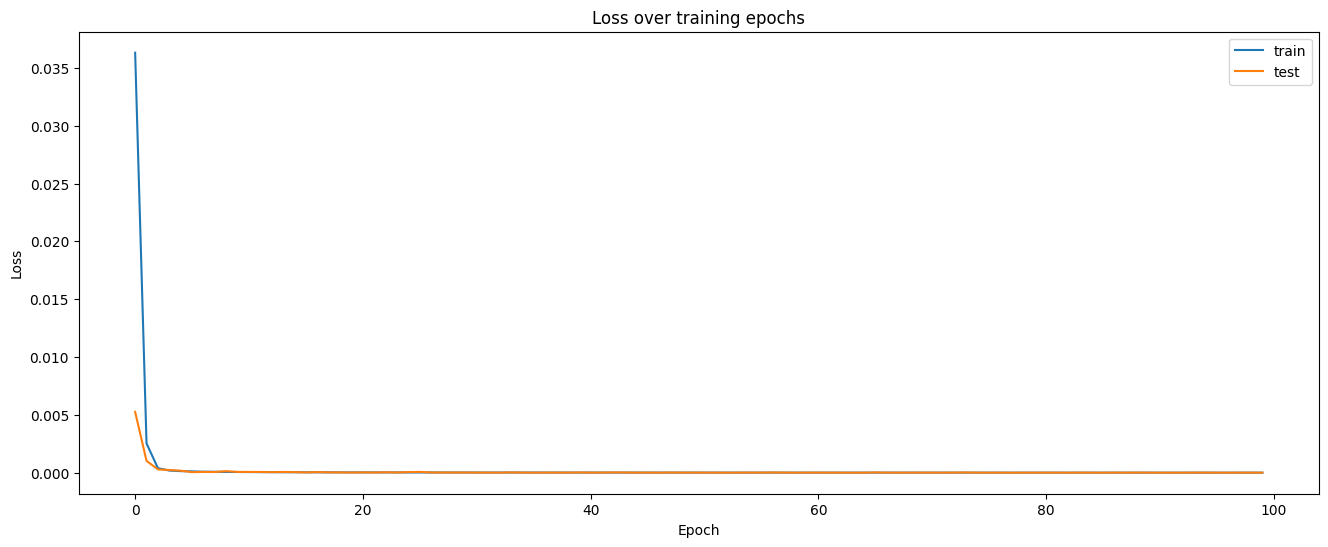

In [62]:
ax = plt.figure(figsize=(16,6)).gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. The size of validation set make it smoothen well too. That'll do for now.

### Saving the model

In [63]:
# Save the model
torch.save(model.state_dict(), MODEL_FILE_NAME)

In [64]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': history['train'],
    'val_loss': history['val']
}, f'cp_{MODEL_FILE_NAME}.pth')

### Choosing a threshold

In [26]:
model.load_state_dict(torch.load(MODEL_FILE_NAME))

<All keys matched successfully>

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [120]:
from torch.utils.data import DataLoader

def predict(model, criterion, dataset, batch_size=16):
  predictions, losses = [], []
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  with torch.no_grad():
    model = model.eval()
    for seq_true in data_loader:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu())
      losses.append(loss.item())

  return predictions, losses

In [121]:
train_predictions, losses = predict(model, criterion, train_sequences)

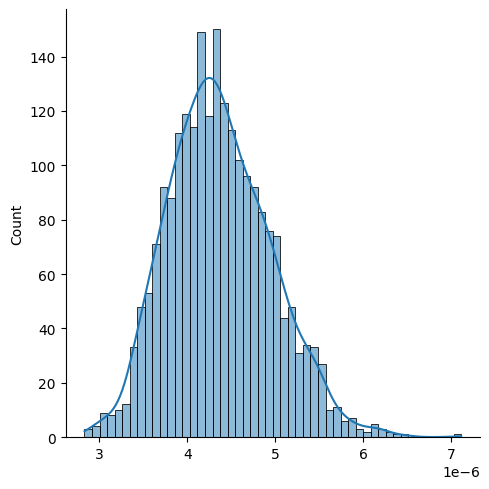

In [122]:
sns.displot(losses, bins=50, kde=True)

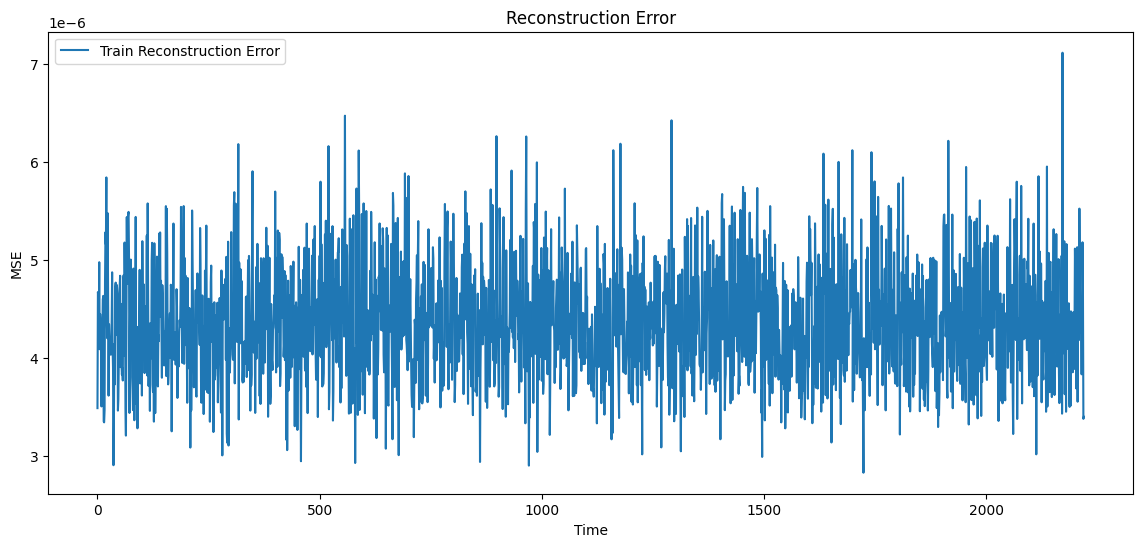

In [123]:
# Plot losses
plt.figure(figsize=(14,6))
plt.plot(losses, label='Train Reconstruction Error')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
plt.title('Reconstruction Error')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.legend()
plt.show()

In [124]:
max_train_losses = np.max(losses)
print(max_train_losses)

7.112873390724417e-06


In [125]:
print(type(train_predictions))
# # Stack into single tensor: shape (N, seq_len, n_features)
all_preds = torch.cat(train_predictions, dim=0)
np_preds = all_preds.numpy()  # shape (N, seq_len, n_features)

<class 'list'>


In [126]:
# print(train_predictions.numpy().shap)
print(train_predictions[0].shape)
print(train_predictions[1])

torch.Size([16, 4, 4])
tensor([[[ 1.0120e-01,  2.6361e-01,  1.9004e-01,  2.9617e-02],
         [-1.4002e-03,  8.5407e-01,  1.6966e-01,  8.8033e-02],
         [ 7.9860e-01,  1.7069e-01,  3.4590e-01,  1.0453e-02],
         [ 6.0254e-01,  9.8796e-01,  3.6634e-01,  2.5937e-01]],

        [[ 1.9985e-01,  8.2753e-01,  5.5425e-01,  5.1177e-01],
         [ 5.0030e-01,  1.7200e-01,  3.2587e-01,  8.8211e-02],
         [ 7.9439e-01,  3.6797e-01,  6.3520e-01,  5.6659e-04],
         [ 1.9390e-01,  8.0492e-02,  7.7201e-01,  9.7967e-02]],

        [[ 7.0114e-01,  5.3894e-01,  9.1464e-02,  3.0500e-02],
         [ 7.9917e-01,  1.1773e-01,  5.7648e-02,  4.9074e-02],
         [ 4.9521e-01,  1.4298e-01,  1.9890e-02,  8.1431e-02],
         [-4.7206e-03,  5.5504e-01,  8.2929e-01,  1.3839e-01]],

        [[ 1.0018e+00,  8.8198e-01,  9.3146e-02,  6.2982e-02],
         [ 1.0019e+00,  1.9834e-01,  1.1252e-03,  7.0164e-02],
         [ 6.9734e-01,  4.5755e-02,  7.1370e-01,  1.6203e-01],
         [ 1.9463e-01,  6.

In [127]:
synthetic_data = np_preds[:, :, 0]
print(synthetic_data.shape)
print(synthetic_data[0])
print(synthetic_data[1])

(35527, 4)
[0.5026678  0.70026547 0.69987977 0.9016535 ]
[0.70043415 0.3001352  0.5987913  0.60192895]


In [128]:
def synthetic_data(predictions):
    all_preds = torch.cat(predictions, dim=0)
    np_preds = all_preds.numpy()  # shape (N, seq_len, n_features)
    synthetic_data = np_preds[:, :, 0] # TODO: to be discussed more!
    synthetic_data = scaler.inverse_transform(synthetic_data)
    synthetic_df = pd.DataFrame(synthetic_data, columns=['Year', 'PROVINCE', 'Week_no', 'Count'])

    synthetic_df[['Year', 'Week_no', 'Count']] = synthetic_df[['Year', 'Week_no', 'Count']].round().astype(int)
    # Map back the encoded province names
    synthetic_df['PROVINCE'] = synthetic_df['PROVINCE'].apply(lambda x: province_code_mapping.get(int(x), 'Unknown'))

    return synthetic_df

In [129]:
test_predictions, test_losses = predict(model, criterion, test_sequences)

In [130]:
test_prediciton_df = synthetic_data(test_predictions)
test_prediciton_df.head()

,Year,PROVINCE,Week_no,Count
0,2016,Mae Hong Son,1,70
1,2020,Amnat Charoen,16,10
2,2022,Tak,27,100
3,2016,Roi Et,6,9
4,2016,Mae Hong Son,37,60


### Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:
- If the reconstruction loss for an example is below the threshold, we'll classify it as a normal
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

In [131]:
THRESHOLD = 97 # Top 3% MSE treated as anomalies

#### Normal
Let's check how well our model does on normal cases. We'll use the normal cases from the test set (our model haven't seen those):

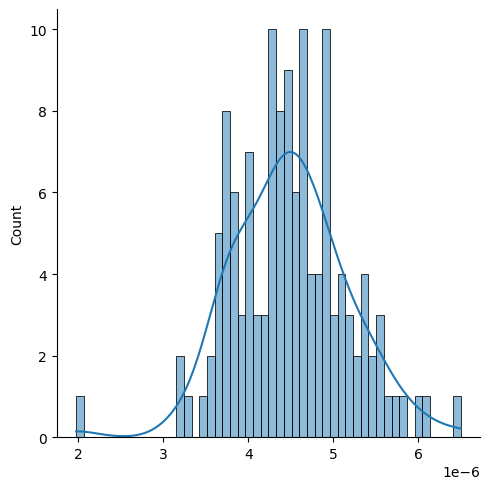

In [132]:
sns.displot(test_losses, bins=50, kde=True)

In [133]:
def calculate_anomaly(losses, threshold):
    # threshold = np.percentile(losses, threshold)
    anomalies = losses > threshold
    # anomalies = anomalies & np.subtract(Predicts, X) < 0
    return anomalies

In [134]:
anomalies = calculate_anomaly(test_losses, max_train_losses)

print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomalies indices: {np.where(anomalies)[0]}")

Number of anomalies detected: 0
Anomalies indices: []


In [135]:
# Compute reconstruction error
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))

# Set Threshold and Detect Anomalies
threshold = np.percentile(mse, THRESHOLD_PERCENTAGE_OF_MSE)  # Top 2% MSE treated as anomaly

# Consider anomalies as those with MSE greater than the threshold, but only when generated data is less than the actual data

anomalies = calculate_anomaly(mse, threshold, X_test, X_pred)

print(f"Anomaly threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomalies: {mse[anomalies]}")
print(f"Anomalies indices: {np.where(anomalies)[0]}")

NameError: name 'X_test' is not defined

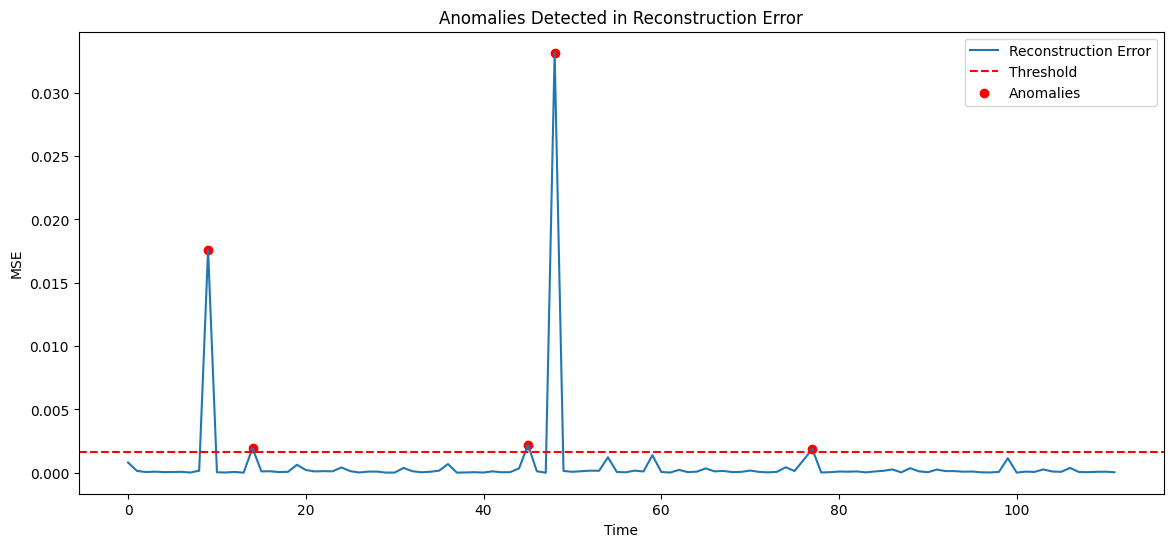

In [ ]:
# Plot detected anomalies 
plt.figure(figsize=(14,6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detected in Reconstruction Error')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
print(X_pred[:, 0, 0])

[0.17846245 0.02066998 0.04276907 0.10794083 0.02695048 0.02605087
 0.02402174 0.04173296 0.14932357 0.478253   0.02902357 0.03091124
 0.02956078 0.07815962 0.34008244 0.07360059 0.17471454 0.06413957
 0.03530534 0.04348959 0.15220238 0.0620665  0.07856251 0.02196449
 0.03668001 0.04765974 0.05675399 0.02396857 0.04799261 0.08026309
 0.03936049 0.1049026  0.02156464 0.02687035 0.072608   0.02060449
 0.2372584  0.0368061  0.03983219 0.04398964 0.17835133 0.16145289
 0.05845404 0.02807094 0.12035677 0.34047446 0.02154111 0.0375984
 0.5707272  0.05736554 0.02388833 0.07751398 0.02030839 0.06713188
 0.09860886 0.07845391 0.0276074  0.12004652 0.03611394 0.15800193
 0.02531697 0.09215953 0.07509708 0.04056197 0.03130747 0.04307177
 0.03216283 0.03940031 0.02643251 0.08879376 0.05276343 0.03806799
 0.06508257 0.05344849 0.10969324 0.02135744 0.04546553 0.11029637
 0.0585528  0.03870952 0.10601512 0.16581894 0.04658757 0.03327691
 0.07461427 0.14038473 0.08685105 0.05882841 0.05065941 0.02264

In [ ]:
def plot_anomalies(X, Predicts, anomalies):
    # Plot prediction vs actual AND scatter the anomalies
    X_first_column = X[:, 0, 0]
    Predicts_first_column = Predicts[:, 0, 0]

    plt.figure(figsize=(14,6))
    plt.plot(X_first_column, label='Actual')
    plt.plot(Predicts_first_column, label='Predicted')
    plt.scatter(np.where(anomalies)[0], X_first_column[anomalies], color='red', label='Anomalies')
    plt.title('Actual vs Predicted Dengue Cases')
    plt.ylabel('Count')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

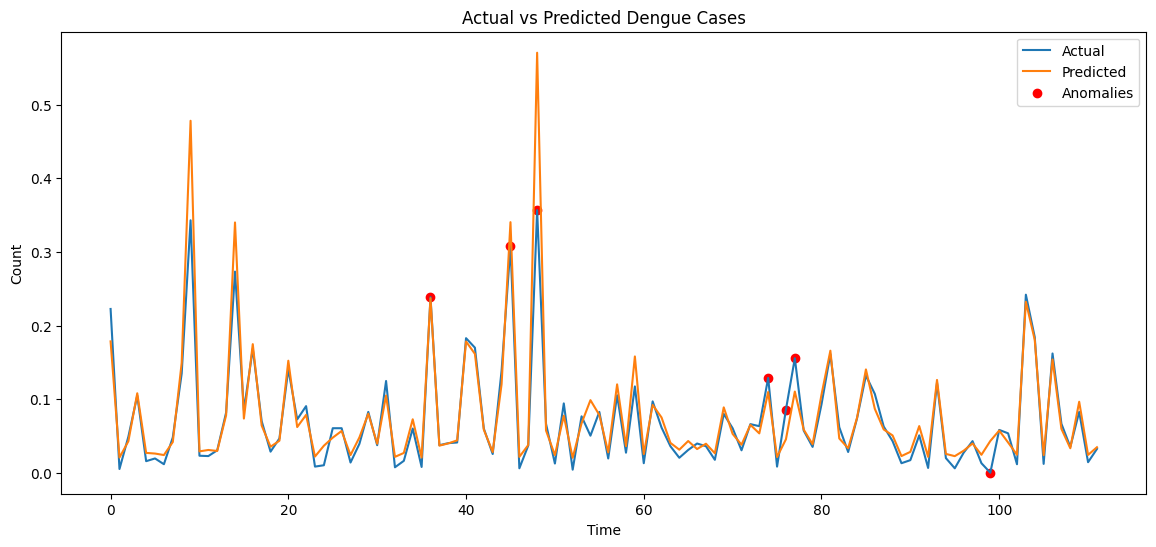

In [ ]:
plot_anomalies(X_test, X_pred, anomalies)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
All Anomalies Count: 23
All Anomalies: [0.00225107 0.00194008 0.00220822 0.00264316 0.0036108  0.00591757
 0.01759989 0.03317105 0.03249435 0.00874489 0.0054196  0.02097597
 0.02110429 0.00994516 0.01893792 0.03374049 0.02104682 0.0127814
 0.01040581 0.00175929 0.00196811 0.0019648  0.00186258]
All Anomalies Indices: [136 137 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 285 518 519 520]


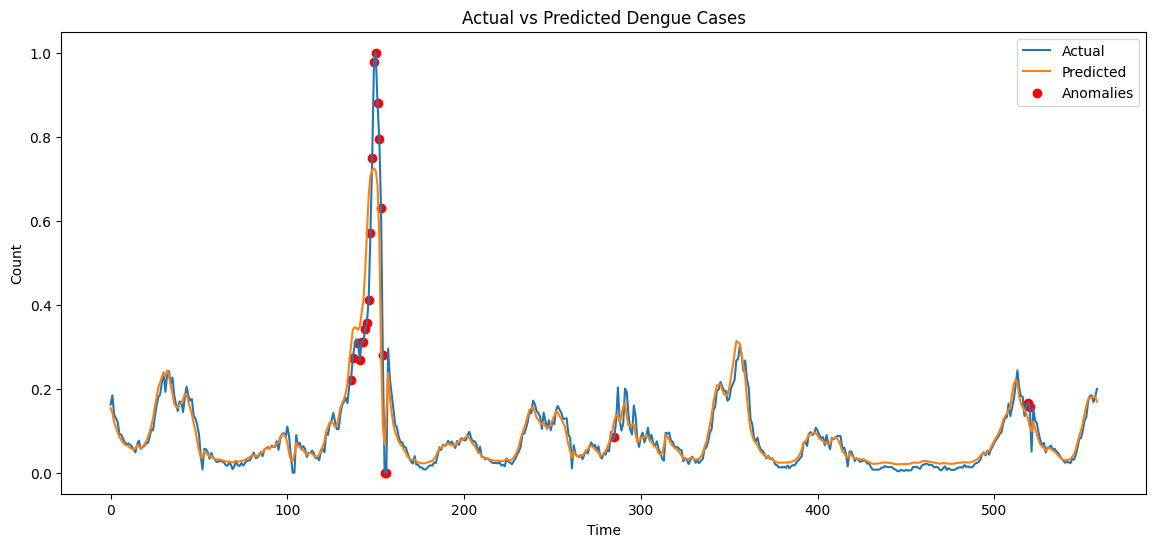

In [ ]:
# Plot all prediction vs actual AND scatter the anomalies points 
all_predictions = model.predict(X)

all_mse = np.mean(np.power(X - all_predictions, 2), axis=(1,2))

all_threshold = np.percentile(all_mse, THRESHOLD_PERCENTAGE_OF_MSE)

all_anomalies = calculate_anomaly(all_mse, all_threshold, X, all_predictions)

print(f"All Anomalies Count: {np.sum(all_anomalies)}")
print(f"All Anomalies: {all_mse[all_anomalies]}")
print(f"All Anomalies Indices: {np.where(all_anomalies)[0]}")

plot_anomalies(X, all_predictions, all_anomalies)

### Dynamic Threshold
Instead of static thresholds (like 95th percentile), we'll use a dynamic thresholding method based on the moving average + standard deviation.

This way:
- The threshold can adapt based on local data behavior.
- It handles seasonality and gradual changes better.

#### Plan
- After computing the reconstruction error (MSE) over time,
- We'll apply a moving average + k times standard deviation window.
- If error > (moving average + k×std), we flag it as an anomaly (outbreak).

In [ ]:
import scipy.stats

# --- 2. Dynamic Thresholding based on Moving Average
def dynamic_threshold(mse_errors, window_size=10, sigma=3):
    """
    Compute dynamic threshold using moving average and moving std deviation
    Args:
        mse_errors (np.array): Reconstruction errors
        window_size (int): size of moving window
        sigma (float): number of std deviations above mean considered anomaly
    Returns:
        thresholds (np.array): Threshold per point
    """
    thresholds = []
    for i in range(len(mse_errors)):
        if i < window_size:
            window = mse_errors[:i+1]
        else:
            window = mse_errors[i-window_size:i]
        
        mean = np.mean(window)
        std = np.std(window)
        thresholds.append(mean + sigma * std)
    return np.array(thresholds)

In [ ]:
# Apply dynamic threshold
window_size = 14

# Higher sigma → fewer, bigger anomalies.
# Lower sigma → more sensitive, more anomalies.
sigma = 3.5

dynamic_thresh = dynamic_threshold(mse, window_size, sigma)


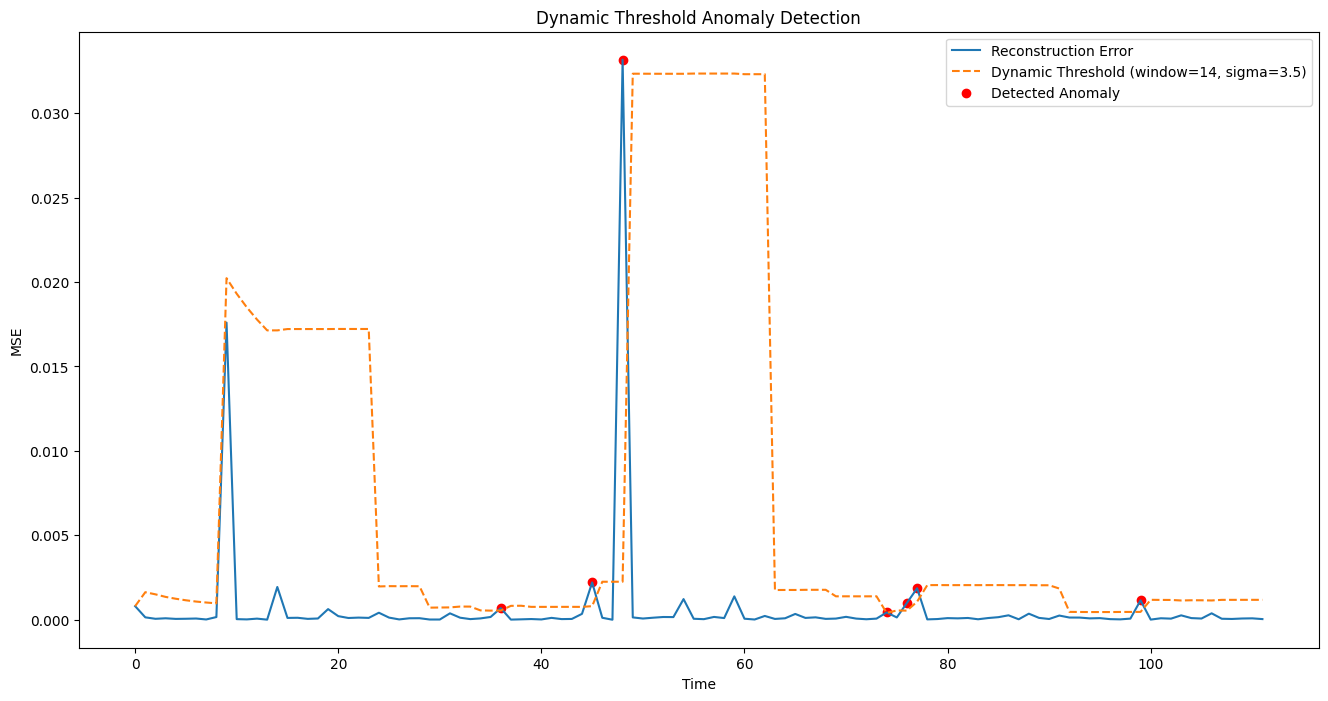

In [ ]:
anomalies = mse > dynamic_thresh

# Plotting Results
plt.figure(figsize=(16,8))
plt.plot(mse, label='Reconstruction Error')
plt.plot(dynamic_thresh, label=f'Dynamic Threshold (window={window_size}, sigma={sigma})', linestyle='--')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Detected Anomaly')
plt.legend()
plt.title('Dynamic Threshold Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()


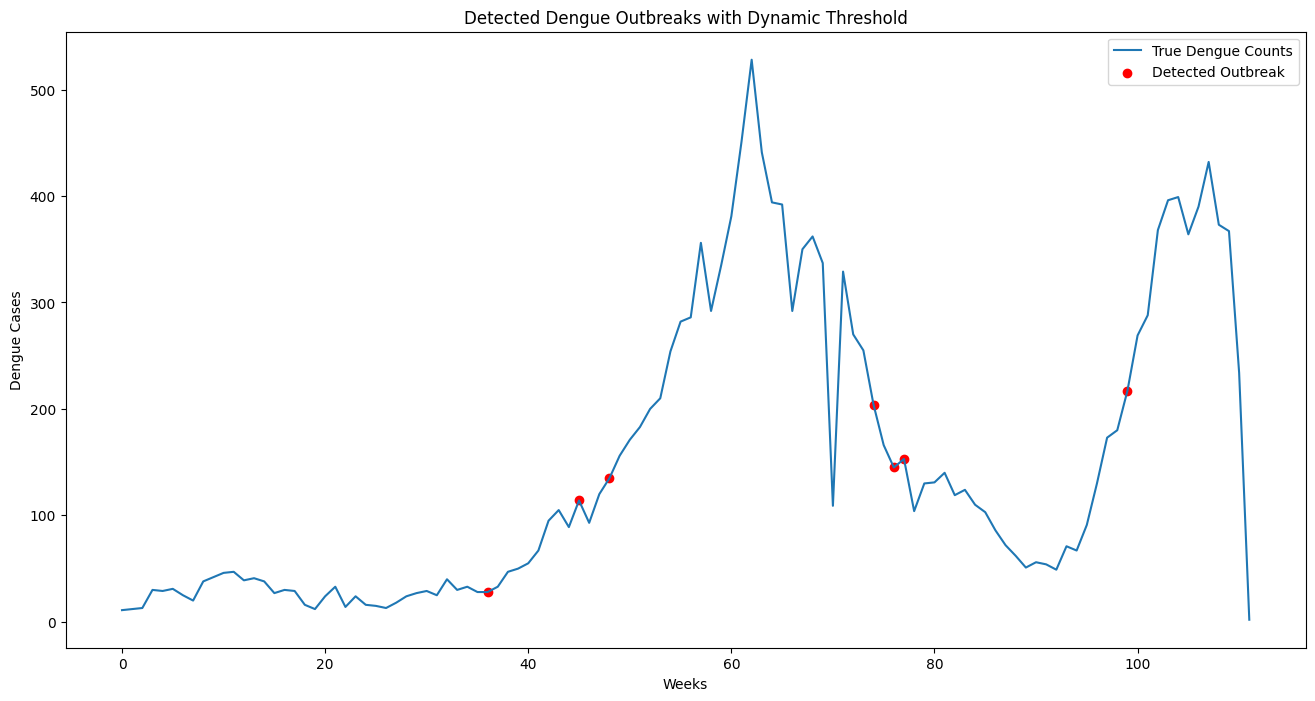

In [ ]:
# --- 5. Plot Anomalies on Real Case Counts
plt.figure(figsize=(16,8))
plt.plot(df.iloc[-len(mse):]['Count'].values, label='True Dengue Counts')
plt.scatter(
    np.where(anomalies)[0],
    df.iloc[-len(mse):]['Count'].values[anomalies],
    color='red',
    label='Detected Outbreak'
)
plt.legend()
plt.title('Detected Dengue Outbreaks with Dynamic Threshold')
plt.xlabel('Weeks')
plt.ylabel('Dengue Cases')
plt.show()


### References
Here are the reference to read:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10452936/ 
- https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/manuscript/06.time-series-anomaly-ecg.md 